In [1]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 659.2 kB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from tqdm import tqdm
from torch import nn, optim
# import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision import transforms
from numpy.random import RandomState
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from torchvision import datasets, transforms
from easyfsl.utils import plot_images, sliding_average

In [3]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes 
        dists = torch.cdist(z_query, z_proto) # ToDo: Try other distance measures.

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True) # ToDo: Try diffrenet backbone model.
convolutional_network.fc = nn.Flatten()
# print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 253MB/s]


In [4]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 25  # Number of images per class in the support set
N_QUERY = 175  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

In [11]:
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.', train=True, transform=transform_train, download=True)

#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.', train=True, transform=transform_val, download=True)


for seed in range(0, 25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
  val_data.get_labels = lambda: [
      target for (img, target) in val_data
  ]

  test_sampler = TaskSampler(
      val_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
  )

  test_loader = DataLoader(
      val_data,
      batch_sampler=test_sampler,
      num_workers=12,
      pin_memory=True,
      collate_fn=test_sampler.episodic_collate_fn,
  )

  evaluate(test_loader)

Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]

Model tested on 100 tasks. Accuracy: 88.12%
Num Samples For Training 50 Num Samples For Val 400



100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


Model tested on 100 tasks. Accuracy: 68.00%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


Model tested on 100 tasks. Accuracy: 77.61%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Model tested on 100 tasks. Accuracy: 86.77%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Model tested on 100 tasks. Accuracy: 75.49%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


Model tested on 100 tasks. Accuracy: 76.18%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:11<00:00,  8.80it/s]

Model tested on 100 tasks. Accuracy: 88.65%
Num Samples For Training 50 Num Samples For Val 400



100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Model tested on 100 tasks. Accuracy: 88.19%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Model tested on 100 tasks. Accuracy: 83.28%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

Model tested on 100 tasks. Accuracy: 71.49%
Num Samples For Training 50 Num Samples For Val 400



100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Model tested on 100 tasks. Accuracy: 81.37%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]

Model tested on 100 tasks. Accuracy: 88.46%
Num Samples For Training 50 Num Samples For Val 400



100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Model tested on 100 tasks. Accuracy: 88.51%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]

Model tested on 100 tasks. Accuracy: 84.98%
Num Samples For Training 50 Num Samples For Val 400



100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


Model tested on 100 tasks. Accuracy: 86.22%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Model tested on 100 tasks. Accuracy: 88.24%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Model tested on 100 tasks. Accuracy: 85.57%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Model tested on 100 tasks. Accuracy: 84.64%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Model tested on 100 tasks. Accuracy: 76.92%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


Model tested on 100 tasks. Accuracy: 70.95%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Model tested on 100 tasks. Accuracy: 92.08%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Model tested on 100 tasks. Accuracy: 82.90%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Model tested on 100 tasks. Accuracy: 84.12%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Model tested on 100 tasks. Accuracy: 74.03%
Num Samples For Training 50 Num Samples For Val 400


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]

Model tested on 100 tasks. Accuracy: 74.43%


In [12]:
print(f'Mean Acc over 25 models: '\
      f'{np.mean(accs)/ 100 :.2%} '\
      f'+- {np.std(accs):.2}')

Mean Acc over 25 models: 81.89% +- 6.6


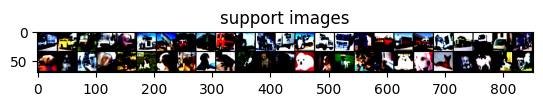

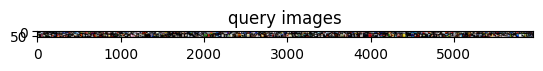

In [7]:
(   example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [10]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

accs = []
def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
    acc = (100 * correct_predictions/total_predictions)
    accs.append(acc)
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


#evaluate(test_loader)